In [542]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data gathering & cleaning

In [543]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [544]:
try:
    path = "/content/drive/MyDrive/CS418/Data_Bandits_CS418/data/crop_data/monthly_prices.csv"
    data = pd.read_csv(path)
    print("Data loaded successfully")
except FileNotFoundError:
    print("File not found")

data.head()

Data loaded successfully


,YEAR,LOCATION,STATE ANSI,ASD CODE,COUNTY ANSI,REFERENCE PERIOD,COMMODITY,GRAIN in $ / BU
0,2001,COLORADO,8,,,JAN,CORN,2.16
1,2001,COLORADO,8,,,FEB,CORN,2.09
2,2001,COLORADO,8,,,MAR,CORN,2.12
3,2001,COLORADO,8,,,APR,CORN,2.11
4,2001,COLORADO,8,,,MAY,CORN,1.98


In [545]:
data = data.drop(columns=['STATE ANSI', 'COUNTY ANSI', 'COMMODITY', 'ASD CODE'])
data = data.rename(columns={
    'LOCATION': 'STATE',
    'REFERENCE PERIOD': 'MONTH',
    'GRAIN in $ / BU': 'PRICE'
})

print(data.head())
print(data.shape)


   YEAR     STATE MONTH PRICE
0  2001  COLORADO   JAN  2.16
1  2001  COLORADO   FEB  2.09
2  2001  COLORADO   MAR  2.12
3  2001  COLORADO   APR  2.11
4  2001  COLORADO   MAY  1.98
(6706, 4)


In [546]:
# redo the index: year-month
#data['MONTH'] = pd.to_datetime(data['MONTH'])
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
data['MONTH'] = data['MONTH'].apply(lambda x: months.index(x) + 1)
data['MONTH'] = pd.to_datetime(data['MONTH'], format='%m').dt.month
data['YEAR'] = pd.to_datetime(data['YEAR'], format='%Y').dt.year
data = data.set_index(['YEAR', 'MONTH', 'STATE'])
data = data.sort_index()


print(data.head())
print(data.shape)

                    PRICE
YEAR MONTH STATE         
2001 1     COLORADO  2.16
           GEORGIA   2.54
           ILLINOIS  1.97
           INDIANA   2.03
           IOWA      1.86
(6706, 1)


In [547]:
# drop the columns with only missing values (if any still exist)
data = data.dropna(axis=1, how='all')

#count the rows with at least one missing value
row_with_nans = data.isna().sum()
print(f"Found {row_with_nans} rows with missing values")

# drop the rows with missing values
data = data.dropna()

#print(data[data['PRICE'].isna() | data['PRCIE']])
#print(data[['PRICE']])

def is_not_a_number(x):
    try:
        float(x)
        return False
    except:
        #print(f"Found a non-number value: {x}")
        return True

data['is_not_a_number'] = data['PRICE'].apply(is_not_a_number)
data = data[data['is_not_a_number'] == False]
data = data.drop(columns=['is_not_a_number'])

print(f"Data shape after dropping rows with missing values: {data.shape}")

# convert every value of PRICE to float
data['PRICE'] = data['PRICE'].astype(float)


print(data.head())
print(data.shape)



Found PRICE    0
dtype: int64 rows with missing values
Data shape after dropping rows with missing values: (5357, 1)
                     PRICE
YEAR MONTH STATE          
2001 1     COLORADO   2.16
           GEORGIA    2.54
           ILLINOIS   1.97
           INDIANA    2.03
           IOWA       1.86
(5357, 1)


In [548]:
# first visualization
# pivot table
data1 = data.copy()
data1['DATE'] = pd.to_datetime(data1.index.get_level_values('YEAR').astype(str)\
                    + '-' + data1.index.get_level_values('MONTH').astype(str))
data1 = data1.reset_index()
pivot_1 = data1.pivot(index='DATE', columns='STATE', values='PRICE')
#pivot_1 = data.pivot(index=['YEAR', 'MONTH'], columns='STATE', values='PRICE')
print(pivot_1.head())
print(pivot_1.shape)

# drop all columns with missing values (and see if we lose too much data)
pivot_1 = pivot_1.dropna(axis=1, how='any')
print(pivot_1.head())
print(pivot_1.shape)


STATE       ALABAMA  ARIZONA  ARKANSAS  COLORADO  GEORGIA  IDAHO  ILLINOIS  \
DATE                                                                         
2001-01-01      NaN      NaN       NaN      2.16     2.54    NaN      1.97   
2001-02-01      NaN      NaN       NaN      2.09     2.58    NaN      2.00   
2001-03-01      NaN      NaN       NaN      2.12     2.57    NaN      2.00   
2001-04-01      NaN      NaN       NaN      2.11     2.67    NaN      1.92   
2001-05-01      NaN      NaN       NaN      1.98     2.31    NaN      1.86   

STATE       INDIANA  IOWA  KANSAS  ...  PENNSYLVANIA  SOUTH CAROLINA  \
DATE                               ...                                 
2001-01-01     2.03  1.86    2.07  ...          2.18             NaN   
2001-02-01     2.01  1.87    2.02  ...          2.35             NaN   
2001-03-01     2.02  1.88    2.07  ...          2.30             NaN   
2001-04-01     1.98  1.83    2.02  ...          2.28             NaN   
2001-05-01     1.95  

In [549]:
# Since we went from 50 columns to 17, let's see if those 17 states are the majhor
# producers identified in another analysis
major_producers = [
    "IOWA", "ILLINOIS", "NEBRASKA", "MINNESOTA", "INDIANA", "SOUTH DAKOTA",
    "KANSAS", "OHIO", "WISCONSIN", "MISSOURI", "MICHIGAN", "NORTH DAKOTA",
    "TEXAS", "KENTUCKY", "COLORADO", "PENNSYLVANIA", "TENNESSEE"
]

print(f"Intersection of major producers and states in the data: {set(major_producers) & set(pivot_1.columns)}")
print(f"Major producers not in the data: {set(major_producers) - set(pivot_1.columns)}")
print(f"States in the data not in the major producers: {set(pivot_1.columns) - set(major_producers)}")




Intersection of major producers and states in the data: {'NEBRASKA', 'OHIO', 'KENTUCKY', 'MICHIGAN', 'MINNESOTA', 'NORTH DAKOTA', 'WISCONSIN', 'COLORADO', 'ILLINOIS', 'MISSOURI', 'PENNSYLVANIA', 'SOUTH DAKOTA', 'TENNESSEE', 'IOWA', 'KANSAS', 'INDIANA'}
Major producers not in the data: {'TEXAS'}
States in the data not in the major producers: set()


In [550]:
# CHOOCE: ignore Texas
print(pivot_1.head())
print(pivot_1.shape)

STATE       COLORADO  ILLINOIS  INDIANA  IOWA  KANSAS  KENTUCKY  MICHIGAN  \
DATE                                                                        
2001-01-01      2.16      1.97     2.03  1.86    2.07      2.18      2.04   
2001-02-01      2.09      2.00     2.01  1.87    2.02      2.28      1.96   
2001-03-01      2.12      2.00     2.02  1.88    2.07      2.20      1.95   
2001-04-01      2.11      1.92     1.98  1.83    2.02      2.08      1.90   
2001-05-01      1.98      1.86     1.95  1.72    1.88      2.08      1.86   

STATE       MINNESOTA  MISSOURI  NEBRASKA  NORTH DAKOTA  OHIO  PENNSYLVANIA  \
DATE                                                                          
2001-01-01       1.81      1.92      1.97          1.62  2.08          2.18   
2001-02-01       1.80      2.01      1.95          1.65  2.01          2.35   
2001-03-01       1.76      1.99      1.98          1.72  2.00          2.30   
2001-04-01       1.77      1.90      1.95          1.69  1.89    

# Exploratory Data Analysis

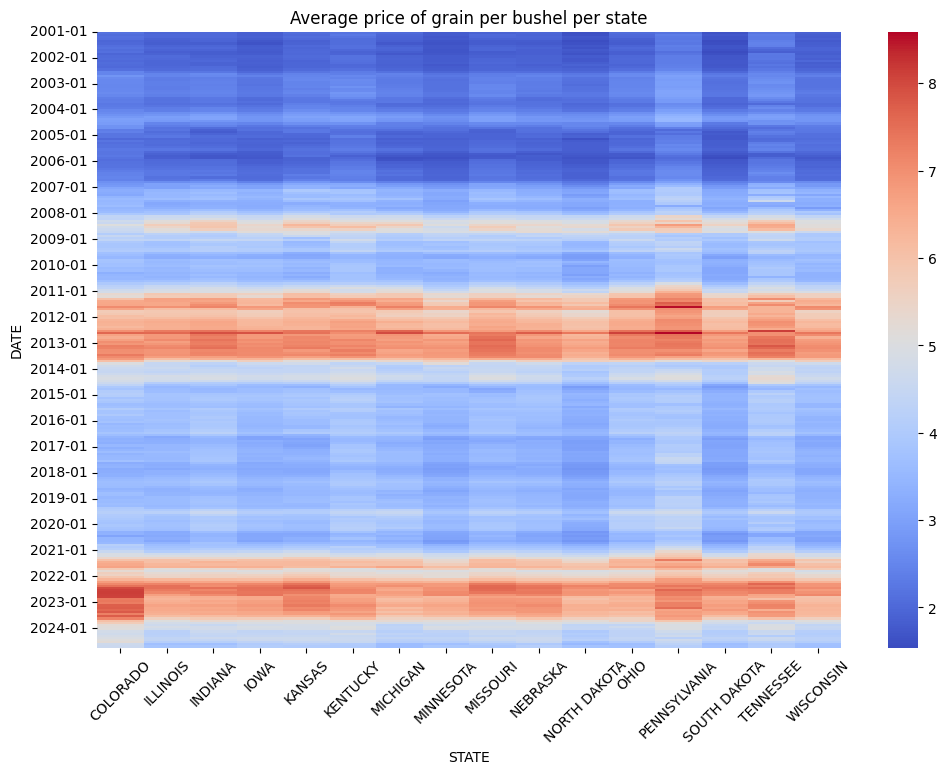

In [551]:
# Now we can plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_1, cmap='coolwarm')
plt.xticks(rotation=45)

year_start_months = pivot_1.index[pivot_1.index.month == 1]
y_ticks = np.arange(0, len(pivot_1.index), 12)  # assuming monthly data, every 12th row
plt.yticks(y_ticks, labels=year_start_months.strftime('%Y-%m'))

plt.title('Average price of grain per bushel per state')
plt.show()

In [552]:
# Since from this visualization we can see that states behave almost consistently
# we can average the prices for all states
pivot_2 = pivot_1.copy()
pivot_2['STATEWISE_AVERAGE'] = pivot_2.mean(axis=1)
pivot_2 = pivot_2.drop(columns=pivot_2.columns[:-1])

print(pivot_2.head())
print(pivot_2.shape)

STATE       STATEWISE_AVERAGE
DATE                         
2001-01-01           1.978750
2001-02-01           1.993750
2001-03-01           1.986250
2001-04-01           1.946250
2001-05-01           1.878125
(285, 1)


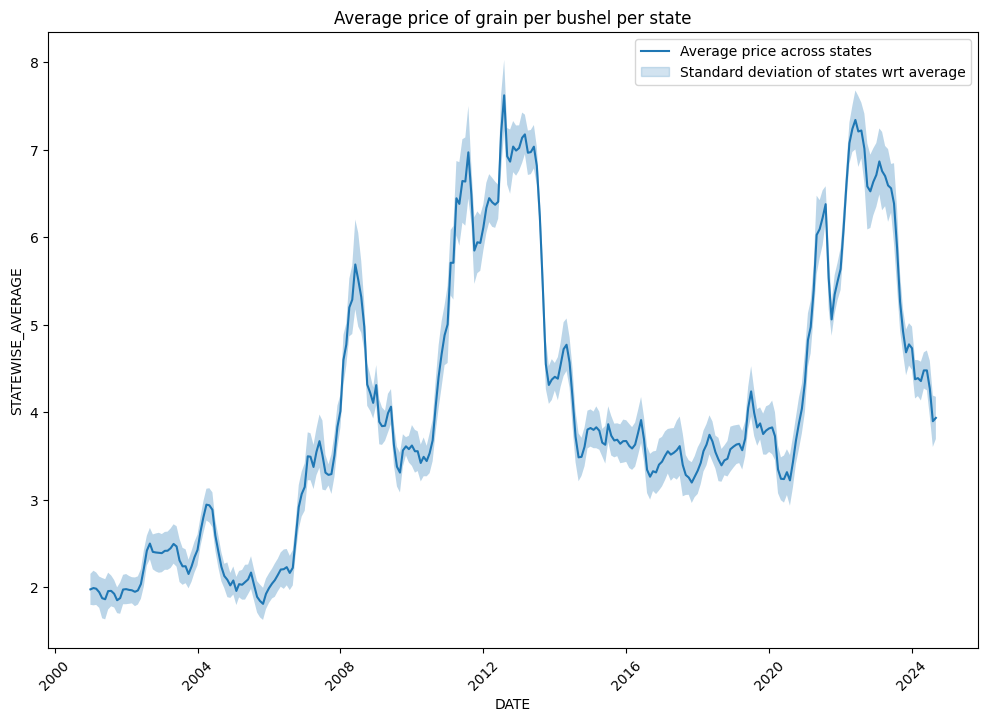

In [553]:
# Now we can do a lineplot
plt.figure(figsize=(12, 8))
sns.lineplot(data=pivot_2, x=pivot_2.index, y='STATEWISE_AVERAGE')
# show the standard variation of each state's value wrt the average
pivot_1['STD'] = pivot_1.std(axis=1)
pivot_2['STD'] = pivot_1['STD'] # copying since pivot_2 dropped the columns needed to compute it
pivot_1 = pivot_1.drop(columns=['STD'])
plt.fill_between(pivot_2.index, pivot_2['STATEWISE_AVERAGE'] - pivot_2['STD'], \
                 pivot_2['STATEWISE_AVERAGE'] + pivot_2['STD'], alpha=0.3)
plt.legend(['Average price across states', 'Standard deviation of states wrt average'])
plt.xticks(rotation=45)
plt.title('Average price of grain per bushel per state')
plt.show()

In [554]:
# Let's see a little bit of statistics
l = len(pivot_1.columns)
interesting_description = pivot_1.columns[:l-1]
pivot_1[interesting_description].describe()

#print(pivot_1.head())
#print(pivot_1.shape)

# Now across states
pivot_3 = pivot_1.copy()
pivot_3['MEAN'] = pivot_1.mean(axis=1)
pivot_3['STD']  = pivot_1.std(axis=1)
pivot_3['25p']  = pivot_1.quantile(0.25, axis=1)
pivot_3['50p']  = pivot_1.quantile(0.5, axis=1)
pivot_3['75p']  = pivot_1.quantile(0.75, axis=1)
pivot_3['MIN']  = pivot_1.min(axis=1)
pivot_3['MAX']  = pivot_1.max(axis=1)
insight = pivot_3[pivot_3.columns[-7:]]
print(f"For all months, years...")
print(insight.head())
print(insight.shape)

print(f"\nStatistics over all periods...")
print(insight.describe())


For all months, years...
STATE           MEAN       STD     25p    50p     75p   MIN   MAX
DATE                                                             
2001-01-01  1.978750  0.177083  1.8825  2.000  2.1000  1.62  2.21
2001-02-01  1.993750  0.197716  1.8600  2.005  2.0375  1.65  2.35
2001-03-01  1.986250  0.185540  1.8625  1.995  2.0825  1.69  2.30
2001-04-01  1.946250  0.178769  1.8450  1.910  2.0350  1.68  2.29
2001-05-01  1.878125  0.230310  1.7650  1.845  1.9575  1.54  2.39
(285, 7)

Statistics over all periods...
STATE        MEAN         STD         25p         50p         75p         MIN  \
count  285.000000  285.000000  285.000000  285.000000  285.000000  285.000000   
mean     4.020068    0.253896    3.864202    4.003596    4.150237    3.620912   
std      1.545620    0.078728    1.507490    1.546371    1.574918    1.466129   
min      1.813125    0.104339    1.685000    1.755000    1.852500    1.540000   
25%      3.067500    0.199390    2.875000    3.015000    3.170000  

In [555]:
# More interestingly, do mean of means per year, avg of minimums/max. per year, avg. of std per year
#print(pivot_1.head())
#print(pivot_1.shape)
#print(pivot_2.head())
#print(pivot_2.shape)

#pivot_4 = pivot_2.copy()
p2_index = pivot_2.index
p2_index = pd.to_datetime(p2_index)
pivot_4 = pd.DataFrame()
pivot_4['STATEWISE AVG'] = pivot_2[['STATEWISE_AVERAGE']].groupby(p2_index.year).mean()
pivot_4['STD'] = pivot_2[['STD']].groupby(p2_index.year).mean()
pivot_4['MIN'] = pivot_1.min(axis=1).groupby(p2_index.year).min()
pivot_4['MAX'] = pivot_1.max(axis=1).groupby(p2_index.year).max()


            STATEWISE AVG       STD   MIN   MAX
DATE                                           
2001-01-01       1.933906  0.186434  1.54  2.44
2001-02-01       1.933906  0.186434  1.54  2.44
2001-03-01       1.933906  0.186434  1.54  2.44
2001-04-01       1.933906  0.186434  1.54  2.44
2001-05-01       1.933906  0.186434  1.54  2.44
(285, 4)


<ipython-input-556-bd0d44b71011>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp3 = temp3.fillna(method='ffill')


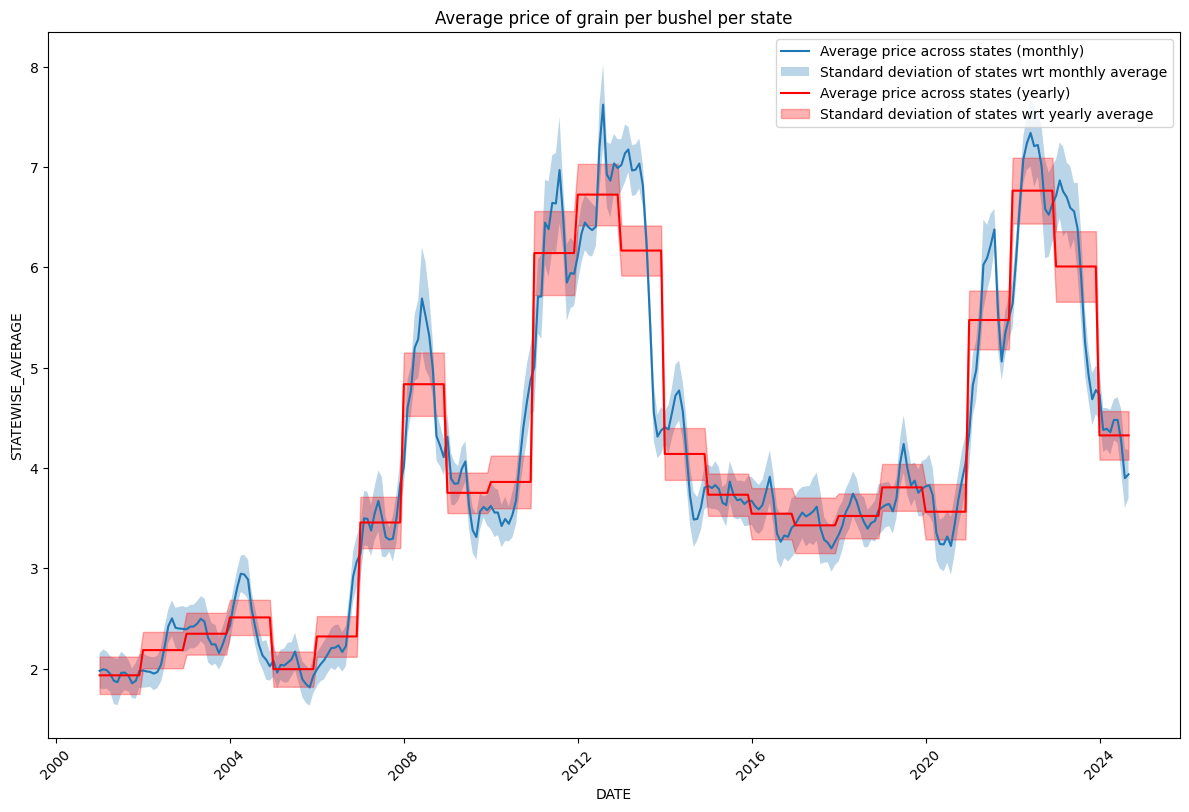

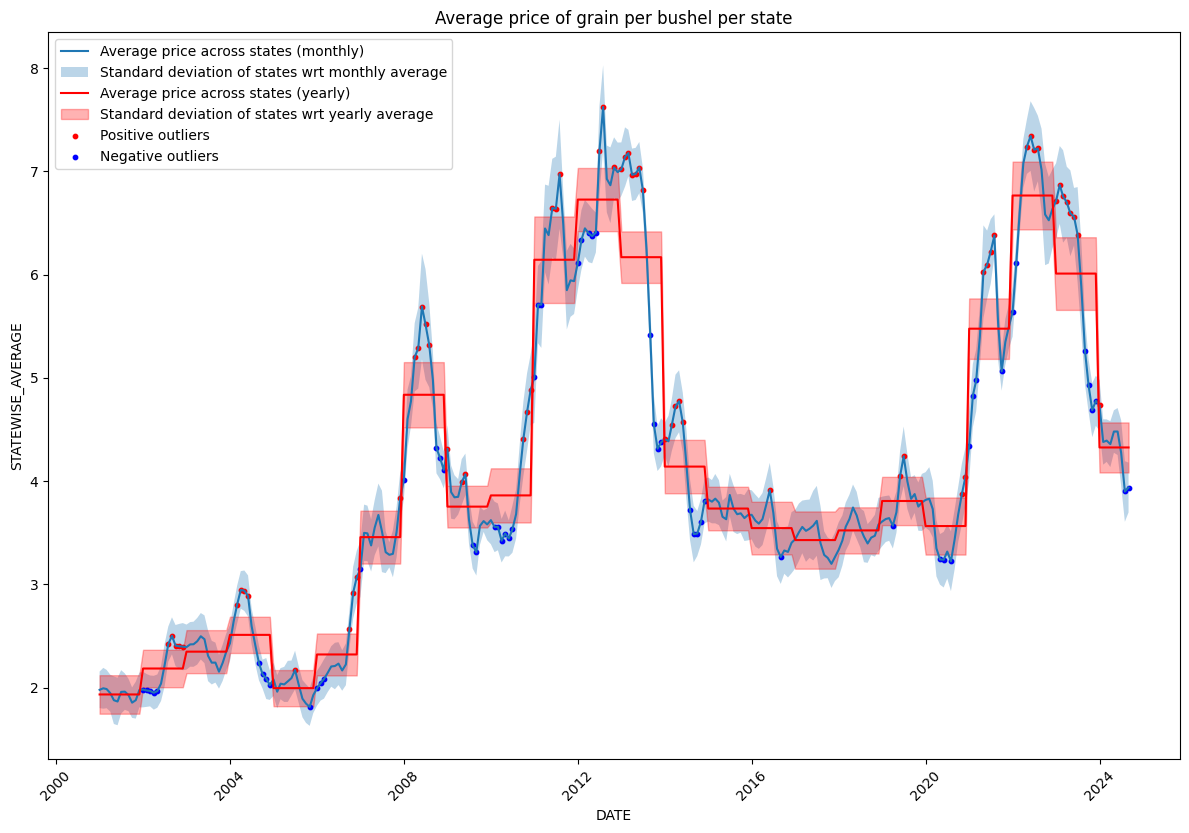

In [556]:
# Assuming pivot_4 is indexed by year (e.g., 2020, 2021, etc.)
# Create a new index for temp3 that includes each month of every year in pivot_4
#temp3_index = pd.date_range(start=f'{pivot_4.index.min()}-01', end=f'{pivot_4.index.max()}-12', freq='M')

temp3_index = pivot_2.index
# Create temp3 with the new index and replicate the values of each year for all months
temp3 = pd.DataFrame(index=temp3_index)

for col in pivot_4.columns:
    temp3[col] = temp3.index.year.map(pivot_4[col])

# Forward-fill any remaining NaN values, if necessary
temp3 = temp3.fillna(method='ffill')

print(temp3.head())
print(temp3.shape)

# pivot_2 contains the statewise avg and statewise std.
# temp3 contains statewise values but aggregted per year.
# Let's plot the two together
plt.figure(figsize=(12, 8))
sns.lineplot(data=pivot_2, x=pivot_2.index, y='STATEWISE_AVERAGE', label='Average price across states (monthly)')
plt.fill_between(pivot_2.index, pivot_2['STATEWISE_AVERAGE'] - pivot_2['STD'], \
                 pivot_2['STATEWISE_AVERAGE'] + pivot_2['STD'], alpha=0.3, label='Standard deviation of states wrt monthly average')
sns.lineplot(data=temp3, x=temp3.index, y='STATEWISE AVG', color='red', label='Average price across states (yearly)')
plt.fill_between(temp3.index, temp3['STATEWISE AVG'] - temp3['STD'], \
                 temp3['STATEWISE AVG'] + temp3['STD'], alpha=0.3, color='red', label='Standard deviation of states wrt yearly average')
#plt.legend(['Average price across states (monthly)', 'Standard deviation of states wrt monthly average', \
#            'Average price across states (yearly)', 'Standard deviation of states wrt yearly average
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.title('Average price of grain per bushel per state')


# now let's use that to highlight the months where the monthly average is above the yearly average + yearly std
pivot_2['YEARLY_AVG'] = temp3['STATEWISE AVG']
pivot_2['YEARLY_STD'] = temp3['STD']
pivot_2['YEARLY_AVG_STD'] = pivot_2['YEARLY_AVG'] + pivot_2['YEARLY_STD']
pivot_2['MONTHLY_ABOVE_YEARLY'] = pivot_2['STATEWISE_AVERAGE'] > pivot_2['YEARLY_AVG_STD']
pivot_2['MONTHLY_ABOVE_YEARLY'] = pivot_2['MONTHLY_ABOVE_YEARLY'].astype(int)
pivot_2['MONTHLY_BELOW_MINUS_YEARLY'] = pivot_2['STATEWISE_AVERAGE'] < pivot_2['YEARLY_AVG'] - pivot_2['YEARLY_STD']
pivot_2['MONTHLY_BELOW_MINUS_YEARLY'] = pivot_2['MONTHLY_BELOW_MINUS_YEARLY'].astype(int)

plt.figure(figsize=(12, 8))
sns.lineplot(data=pivot_2, x=pivot_2.index, y='STATEWISE_AVERAGE', label='Average price across states (monthly)')
plt.fill_between(pivot_2.index, pivot_2['STATEWISE_AVERAGE'] - pivot_2['STD'], \
                 pivot_2['STATEWISE_AVERAGE'] + pivot_2['STD'], alpha=0.3, label='Standard deviation of states wrt monthly average')
sns.lineplot(data=temp3, x=temp3.index, y='STATEWISE AVG', color='red', label='Average price across states (yearly)')
plt.fill_between(temp3.index, temp3['STATEWISE AVG'] - temp3['STD'], \
                 temp3['STATEWISE AVG'] + temp3['STD'], alpha=0.3, color='red', label='Standard deviation of states wrt yearly average')
# let's use a red-dot scatter plot to highlight the months where the monthly average is above the yearly average + yearly std
#plt.scatter(pivot_2.index, pivot_2['STATEWISE_AVERAGE'], c=pivot_2['MONTHLY_ABOVE_YEARLY'], s=10)
#plt.scatter(pivot_2.index, pivot_2['STATEWISE_AVERAGE'], c=pivot_2['MONTHLY_BELOW_MINUS_YEARLY'], s=10)
plt.scatter(
    pivot_2.index[pivot_2['MONTHLY_ABOVE_YEARLY'] == 1],
    pivot_2['STATEWISE_AVERAGE'][pivot_2['MONTHLY_ABOVE_YEARLY'] == 1],
    c='red', s=10, label='Positive outliers'
)
plt.scatter(
    pivot_2.index[pivot_2['MONTHLY_BELOW_MINUS_YEARLY'] == 1],
    pivot_2['STATEWISE_AVERAGE'][pivot_2['MONTHLY_BELOW_MINUS_YEARLY'] == 1],
    c='blue', s=10, label='Negative outliers'
)

#plt.legend(['Average price across states (monthly)', 'Standard deviation of states wrt monthly average', \
#            'Average price across states (yearly)', 'Standard deviation of states wrt yearly average',''\
#            'Positive and negative outliers'])
plt.tight_layout()
plt.legend()
plt.xticks(rotation=45)
plt.title('Average price of grain per bushel per state')

outliers = pivot_2[(pivot_2['MONTHLY_ABOVE_YEARLY'] == 1) | (pivot_2['MONTHLY_BELOW_MINUS_YEARLY'] == 1)]

plt.show()


In [557]:
print(outliers.head())
print(outliers.shape)

STATE       STATEWISE_AVERAGE       STD  YEARLY_AVG  YEARLY_STD  \
DATE                                                              
2002-01-01           1.981250  0.172351    2.185156    0.181222   
2002-02-01           1.972500  0.158682    2.185156    0.181222   
2002-03-01           1.968125  0.149498    2.185156    0.181222   
2002-04-01           1.950625  0.163970    2.185156    0.181222   
2002-05-01           1.966250  0.160992    2.185156    0.181222   

STATE       YEARLY_AVG_STD  MONTHLY_ABOVE_YEARLY  MONTHLY_BELOW_MINUS_YEARLY  
DATE                                                                          
2002-01-01        2.366379                     0                           1  
2002-02-01        2.366379                     0                           1  
2002-03-01        2.366379                     0                           1  
2002-04-01        2.366379                     0                           1  
2002-05-01        2.366379                     0        

# Hypothesis testing
First, let's test a simple hypothesis:
H0 : The average price for year 2024 is higher than for year 2001

In [558]:
print(f"Pivot_2:")
print(pivot_2.head())
print(pivot_2.shape)
print(f"Pivot_3:")
print(pivot_3.head())
print(pivot_3.shape)
print(f"Pivot_4:")
print(pivot_4.head())
print(pivot_4.shape)


Pivot_2:
STATE       STATEWISE_AVERAGE       STD  YEARLY_AVG  YEARLY_STD  \
DATE                                                              
2001-01-01           1.978750  0.177083    1.933906    0.186434   
2001-02-01           1.993750  0.197716    1.933906    0.186434   
2001-03-01           1.986250  0.185540    1.933906    0.186434   
2001-04-01           1.946250  0.178769    1.933906    0.186434   
2001-05-01           1.878125  0.230310    1.933906    0.186434   

STATE       YEARLY_AVG_STD  MONTHLY_ABOVE_YEARLY  MONTHLY_BELOW_MINUS_YEARLY  
DATE                                                                          
2001-01-01         2.12034                     0                           0  
2001-02-01         2.12034                     0                           0  
2001-03-01         2.12034                     0                           0  
2001-04-01         2.12034                     0                           0  
2001-05-01         2.12034                     

In [559]:
'''
H0 : The average price for year 2024 is higher than for year 2001
Ha: The average price for year 2024 is not higher than for year 2001
'''

pivot_5 = pivot_2.copy()
# drop every colum except the first one
pivot_5 = pivot_5.drop(columns=pivot_5.columns[1:])
pivot_5['YEAR'] = pivot_5.index.year
pivot_5 = pivot_5.reset_index(drop=True)
pivot_5 = pivot_5.set_index('YEAR')

#print(pivot_5.head())
#print(pivot_5.shape)

# Now we can test the hypothesis
year_2001 = pivot_5.loc[2001]
year_2024 = pivot_5.loc[2024]

#print(year_2001)
#print(year_2024)

from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(year_2024, year_2001, alternative='greater')

alpha = 0.05

print(f"Null hyp.: the 2024 avg is not greater than the 2001 one")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

if p_val < alpha:
    print("Reject the null hypothesis: Conclusion: 2024's average is greter than the 2001's one")
else:
    print("Fail to reject the null hypothesis")

Null hyp.: the 2024 avg is not greater than the 2001 one
T-statistic: [30.88246272]
P-value: [5.2715813e-18]
Reject the null hypothesis: Conclusion: 2024's average is greter than the 2001's one


In [560]:
mean_2001 = year_2001.mean()
mean_2024 = year_2024.mean()

print(f"Mean for 2001: {mean_2001}")
print(f"Mean for 2024: {mean_2024}")

Mean for 2001: STATE
STATEWISE_AVERAGE    1.933906
dtype: float64
Mean for 2024: STATE
STATEWISE_AVERAGE    4.325625
dtype: float64
